In [1]:
using LinearAlgebra, Random, Statistics, Plots
pyplot(grid=false)
using LaTeXStrings
include("proxgrad.jl")
import LowRankModels: Loss
using LowRankModels

In [2]:
"""plot line w*x+b=0"""
function plotline!(w::Array{Float64,1},b::Number,
                  xmin::Number=-100,xmax::Number=100; 
                  kwargs...)
    x1samples = [xmin, xmax]
    # w[1]*x[1]+w[2]*x[2]+b = 0
    pred(x1) = -b-w[1]*x1/w[2]
    x2samples = pred.(x1samples) #(-b - w[1]*x1samples)/w[2]
    plot!(x1samples, x2samples; kwargs...)
end
# plotline!([1.,2.], 3, color="red", label="a line")

plotline!

In [3]:
# Generate and plot data
Random.seed!(5)
plotcolor = ["blue", "red", "cyan", "magenta"]
plotshape = [:circle, :diamond, :utriangle, :star5]
n = 20
function sample_data(num_points; noise=1)
    X1 = randn(n,2)*noise .+ [4 0]
    y1 = fill(1,n)
    X2 = randn(n,2)*noise .+ [-3 3]
    y2 = fill(2,n)
    X3 = randn(n,2)*noise .+ [-3 -3]
    y3 = fill(3,n)    
    return vcat(X1,X2,X3), vcat(y1,y2,y3)
end
X,y = sample_data(n)

([5.46430713016804 -0.5206684964371484; 4.26087113108691 1.1675220009018015; … ; -3.771507191877702 -2.7418310403963333; -1.646037142395838 -3.8333769994208033], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

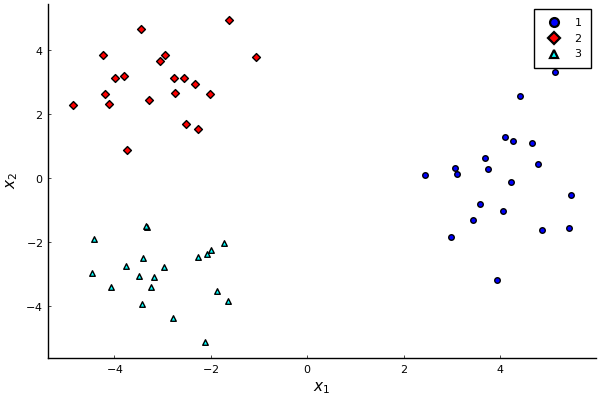

In [4]:
"""function to plot the above data"""
function plotdata(X=X,y=y; margin=.05)
    scatter(X[y.==1,1],X[y.==1,2], color=plotcolor[1], markershape=plotshape[1],label="1")
    scatter!(X[y.==2,1],X[y.==2,2], color=plotcolor[2], markershape=plotshape[2],label="2")
    scatter!(X[y.==3,1],X[y.==3,2], color=plotcolor[3], markershape=plotshape[3],label="3")            
    xlabel!(L"x_1")
    ylabel!(L"x_2")
    range_y = maximum(X[:,2]) - minimum(X[:,2])
    range_x = maximum(X[:,1]) - minimum(X[:,1])
    ylims!((minimum(X[:,2])-margin*range_y,maximum(X[:,2])+margin*range_y))
    xlims!((minimum(X[:,1])-margin*range_x,maximum(X[:,1])+margin*range_x))
end
plotdata()
# savefig("nominal_data.pdf")

In [5]:
function plot_imputed!(l::Loss, X, w, color, shape)
    yhat = impute([l], X*w)
    for l in sort(unique(yhat))
        levell = vec(yhat.==l)
        scatter!(X[levell,1], X[levell,2], color=color[l], markershape=shape[l], alpha=.15, label="$l (imputed)")
    end
end

plot_imputed! (generic function with 1 method)

# One-vs-All Hinge Loss

In [6]:
n = length(y)
Xoffset = [X ones(n)]
loss = OvALoss(3, bin_loss = LogisticLoss())
mul!(loss, 1/n)
w_ova = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1/norm(Xoffset)^2, maxiters=2000)

3×3 Array{Float64,2}:
  0.815993    -0.330475  -0.319302
 -0.00453529   0.675815  -0.670493
 -0.120568    -0.248513  -0.250509

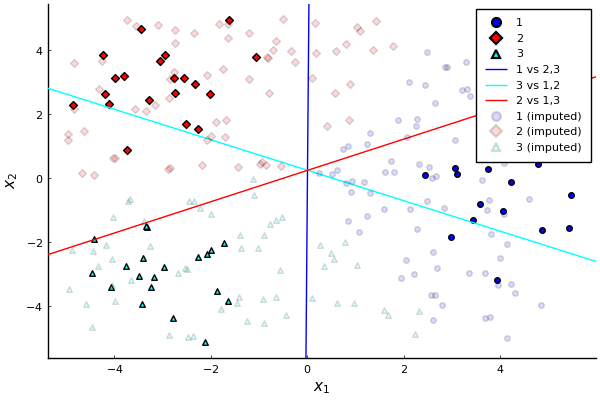

In [7]:
# plot the fit
p = plotdata()
plotline!(w_ova[1:2,1], w_ova[3,1]; label="1 vs 2,3", color=plotcolor[1])
plotline!(w_ova[1:2,3], w_ova[3,3]; label="3 vs 1,2", color=plotcolor[3])
plotline!(w_ova[1:2,2], w_ova[3,2]; label="2 vs 1,3", color=plotcolor[2])
ntest = 200
Xtest = [-5 .+ 10*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, w_ova, plotcolor, plotshape)
# savefig("ova.pdf")
p

# multinomial logit

In [8]:
Xoffset = [X ones(n)]
loss = MultinomialLoss(3)
mul!(loss, 1/n)
w_mnl = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1, maxiters=200)

3×3 Array{Float64,2}:
  1.80506    -0.969873   -0.835187
 -0.0803483   1.68943    -1.60909
  0.0545364   0.0111455  -0.0656818

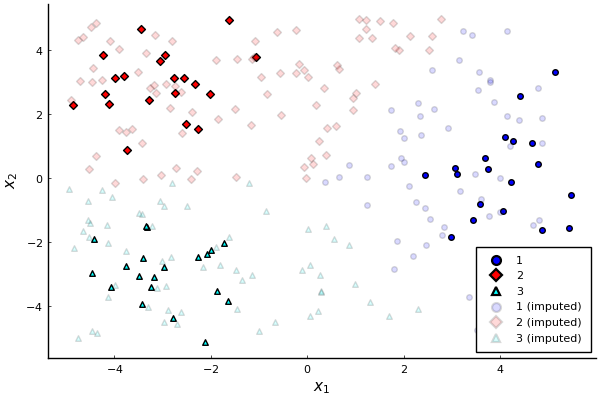

In [9]:
# plot the fit
p=plotdata()
ntest = 200
Xtest = [-5 .+ 10*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, w_mnl, plotcolor, plotshape)
# savefig("mnl.pdf")
p

# Ordinal data

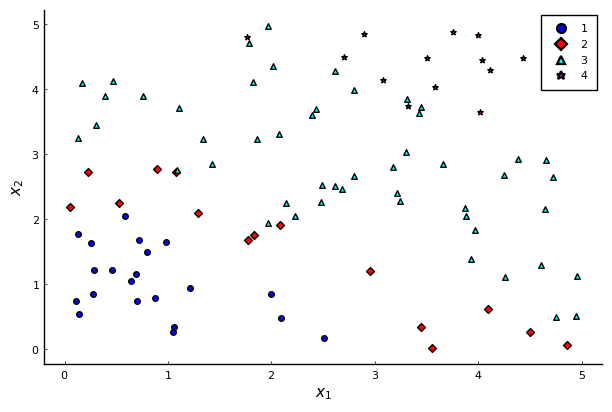

In [10]:
# Generate and plot data
Random.seed!(2)
n = 100
function sample_ord_data(num_points, num_levels; noise=.05)
    X = 5*rand(num_points, 2)   
    w♮ = rand(2)
    z = X*w♮
    znorm = -minimum(z) .+ z
    znorm = znorm ./ maximum(znorm)
    b = [.25, .4, .8]
    y = sum(znorm + noise*randn(num_points) .>= b', dims=2) .+ 1
#    @show sum(znorm + noise*randn(num_points) .>= ones(n)*b', dims=2)
    return X,vec(y)
end
X,y = sample_ord_data(n, 4)

"""function to plot the above data"""
function plot_ord_data(X=X,y=y; margin=.05)
    p=plot()
    for i=1:4
        leveli = vec(y.==i)
        scatter!(X[leveli,1],X[leveli,2], color=plotcolor[i], shape=plotshape[i], label="$i")
    end
    xlabel!(L"x_1")
    ylabel!(L"x_2")
    range_y = maximum(X[:,2]) - minimum(X[:,2])
    range_x = maximum(X[:,1]) - minimum(X[:,1])
    ylims!((minimum(X[:,2])-margin*range_y,maximum(X[:,2])+margin*range_y))
    xlims!((minimum(X[:,1])-margin*range_x,maximum(X[:,1])+margin*range_x))
    p
end
plot_ord_data()
savefig("ord_data.pdf")

# Ordinal Hinge Loss

w_ordhinge = [0.3834258173787001, 0.6289543073566957, 0.11925000000000063]


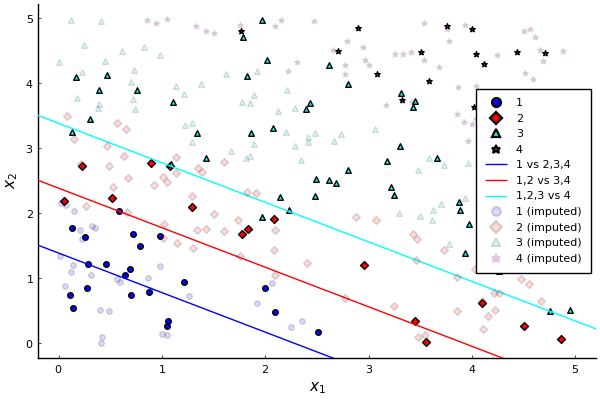

In [11]:
Xoffset = [X ones(n)]
loss = OrdinalHingeLoss(1,4)
mul!(loss, 1/n)
w_ordhinge = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1, maxiters=200)
@show w_ordhinge

# plot the fit
p=plot_ord_data()
plotline!(w_ordhinge[1:2], w_ordhinge[3] - 1.5, color=plotcolor[1], label="1 vs 2,3,4")
plotline!(w_ordhinge[1:2], w_ordhinge[3] - 2.5, color=plotcolor[2], label="1,2 vs 3,4")
plotline!(w_ordhinge[1:2], w_ordhinge[3] - 3.5, color=plotcolor[3], label="1,2,3 vs 4")
ntest = 200
Xtest = [5*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, reshape(w_ordhinge, (3,1)), plotcolor, plotshape)
# savefig("ord_hinge.pdf")
p

In [12]:
# Bigger vs Smaller Loss

w_bvs = [3.9205818285581797 3.2064565328220045 1.7897302542628848; 5.461072316129848 5.30562035357089 3.1134446455224123; -13.262164023681185 -17.189009576969045 -18.46233529383611]


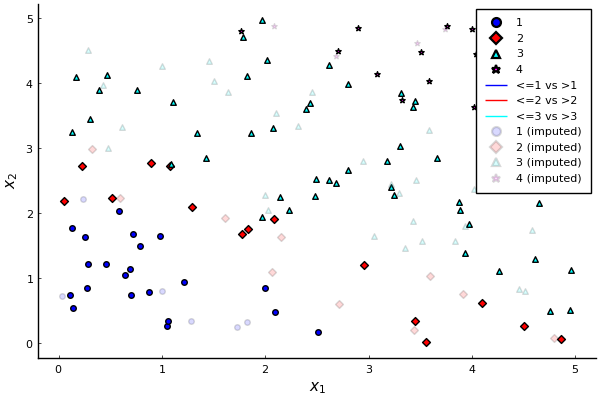

In [13]:
Xoffset = [X ones(n)]
loss = BvSLoss(4, bin_loss=LogisticLoss())
mul!(loss, 1/n)
w_bvs = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1, maxiters=5000)
@show w_bvs

# plot the fit
p=plot_ord_data()
for i=1:3
    plotline!(w_bvs[1:2,i], w_bvs[3,i], color=plotcolor[i], label="<=$i vs >$i")
end
ntest = 50
Xtest = [5*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, w_bvs, plotcolor, plotshape)
# savefig("bvs_zeroreg.pdf")
p

w_bvs = [2.671721049101887 2.671721049101887 2.671721049101887; 4.241607190484742 4.241607190484742 4.241607190484742; -9.808352747236261 -13.970107764689265 -25.68654223721242]


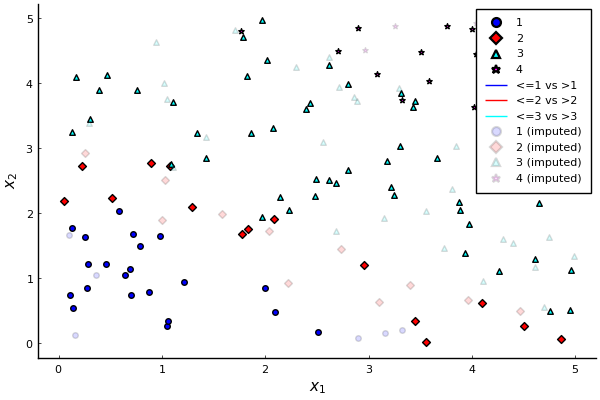

In [14]:
Xoffset = [X ones(n)]
loss = BvSLoss(4, bin_loss=LogisticLoss())
mul!(loss, 1/n)
w_bvs = proxgrad(loss, OrdinalReg(), Xoffset, y, stepsize=1, maxiters=5000)
@show w_bvs

# plot the fit
p=plot_ord_data()
for i=1:3
    plotline!(w_bvs[1:2,i], w_bvs[3,i], color=plotcolor[i], label="<=$i vs >$i")
end
ntest = 50
Xtest = [5*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, w_bvs, plotcolor, plotshape)
# savefig("bvs_ordinalreg.pdf")
p